<a href="https://colab.research.google.com/github/niri-sky/occular_disease_recognition/blob/irina/diabetic_gauss_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retinopathy Detection


# Importing Libraries


In [44]:
import numpy as np
from scipy import misc
from PIL import Image
from skimage import exposure
from sklearn import svm
import scipy.signal
from skimage.exposure import rescale_intensity
import argparse
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

import scipy
from math import sqrt,pi
from numpy import exp
from matplotlib import pyplot as plt
import numpy as np
import glob
import matplotlib.pyplot as pltss
import cv2
from matplotlib import cm
import pandas as pd
from math import pi, sqrt
import pywt
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import glob
from sklearn.model_selection import GridSearchCV, train_test_split

# Importing image files

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
eye_diabetic = !unzip /content/gdrive/MyDrive/cleaned_eye_images/retinopathy.zip
eye_normal= !unzip /content/gdrive/MyDrive/cleaned_eye_images/normal.zip


### Setting random seed for reproducibility:


In [10]:
np.random.seed(42)

#### Loading images and saving as an array:

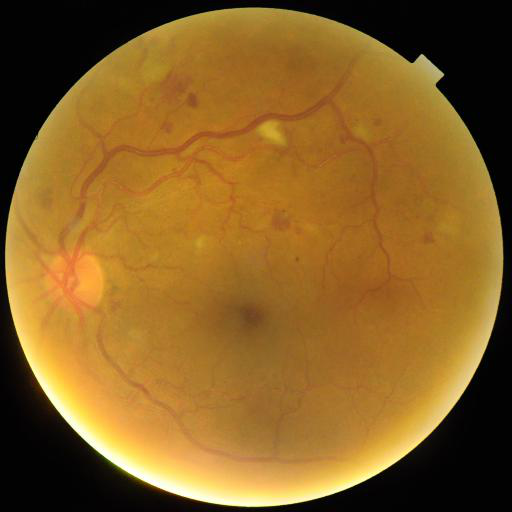

In [11]:
retinopathy = load_img('gdrive/MyDrive/cleaned_eye_images/retinopathy/101_cleaned.jpg')
retinopathy

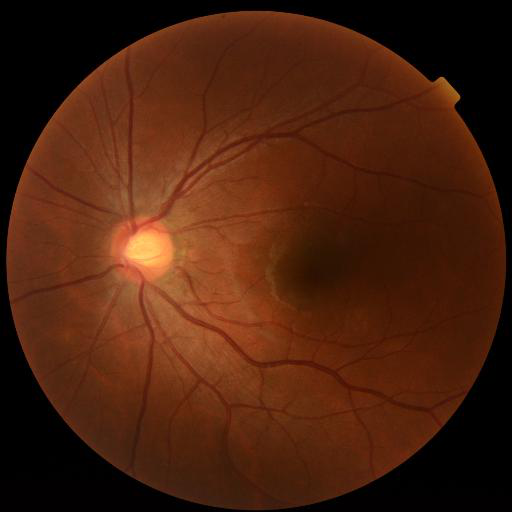

In [13]:
normal = load_img('gdrive/MyDrive/cleaned_eye_images/normal/NL_001_cleaned.jpg')
normal

### Loading retinopathy images:

In [14]:
# Testing cv2:
img = cv2.imread('gdrive/MyDrive/cleaned_eye_images/retinopathy/101_cleaned.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
equ = cv2.equalizeHist(img_gray) 

In [15]:
# Reading images with cv2, converting them to grey scale and creatin an array:
retin_array = []
for f in glob.glob(os.path.join('gdrive/MyDrive/cleaned_eye_images/retinopathy/', "*.jpg")):
    try:
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        equ = cv2.equalizeHist(img_gray)
        retin_array.append(np.array(equ).flatten())
    except:
        shutil.copy2(f, myfolder_path + 'temp.jpg')
        img = cv2.imread(myfolder_path + 'temp.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        os.remove(myfolder_path + 'temp.jpg')
print(f'{len(retin_array)} pictures converted.') 

476 pictures converted.


### Loading normal images:

In [16]:
norm_array = []
for f in glob.glob(os.path.join('gdrive/MyDrive/cleaned_eye_images/normal/', "*.jpg")):
    try:
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        equ_n = cv2.equalizeHist(img_gray)
        norm_array.append(np.array(equ_n).flatten())
    except:
        shutil.copy2(f, myfolder_path + 'temp.jpg')
        img = cv2.imread(myfolder_path + 'temp.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        os.remove(myfolder_path + 'temp.jpg')
print(f'{len(norm_array)} pictures converted.') 

300 pictures converted.


#### Visualizing random retinopathy image after convertions:

In [17]:
# Shape of the image:
np.shape(equ)

(512, 512)

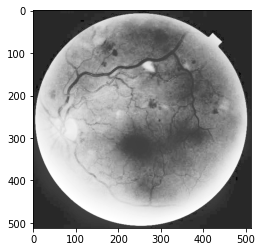

In [18]:
np.shape(retin_array)
np.shape(equ)
plt.imshow(retin_array[61].reshape((512, 512)),cmap='gray')
plt.show()

#### Visualizing random normal image after convertions:

In [19]:
# Shape of the image:
np.shape(equ_n)

(512, 512)

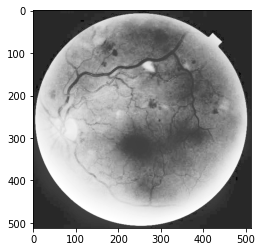

In [20]:
np.shape(norm_array)
np.shape(equ_n)
plt.imshow(norm_array[61].reshape((512, 512)),cmap='gray')
plt.show()

# Image Pocessing

Image processing plays an important role because without it we train our models to learn noise. There are a lot of filters that can be used to process images. In this project, I will use the most common filters such as mean, median, Gaussian and Sobel edge detection fiter.

### Performing discrete wavelet transform:

The Fourier Transform uses a series of sine-waves with different frequencies to analyze a signal. That is, a signal is represented through a linear combination of sine-waves.
The Wavelet Transform uses a series of functions called wavelets, each with a different scale. The word wavelet means a small wave, and this is exactly what a wavelet is (https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/)

#### The different types of wavelet families:

In [ ]:
print(pywt.families(short=False))

['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']


Each type of wavelets has a different shape, smoothness and compactness and is useful for a different purpose. I will be using Haar wavelet.

#### Transforming retinopathic eye:

In [21]:
retin_haar = []
for equ in retin_array:
    equ = equ.reshape((512, 512))
    coeffs = pywt.dwt2(equ, 'haar')
    equ2 = pywt.idwt2(coeffs, 'haar')
    retin_haar.append(np.array(equ2).flatten())

#### Visualizing random retinopathic image:

In [22]:
np.shape(retin_haar)

(476, 262144)

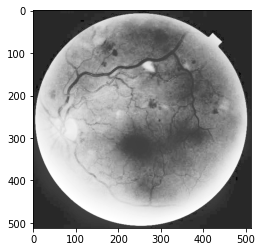

In [23]:
np.shape(equ2)
plt.imshow(retin_haar[61].reshape((512, 512)),cmap='gray')
plt.show()

#### Transforming normal eye:

In [24]:
norm_haar = []
for equ_n in norm_array:
    equ_n = equ_n.reshape((512, 512))
    coeffs = pywt.dwt2(equ_n, 'haar')
    equ2_n = pywt.idwt2(coeffs, 'haar')
    norm_haar.append(np.array(equ2_n).flatten())

#### Visualizing random normal image:

In [25]:
np.shape(norm_haar)

(300, 262144)

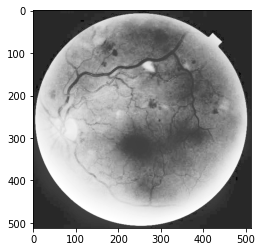

In [26]:
np.shape(equ2_n)
plt.imshow(norm_haar[61].reshape((512, 512)),cmap='gray')
plt.show()

## Applying filters

### Mean filter

Mean filter is a low-pass filter that computes the average of the pixel intensities at any given point. It is used to reduce the noise in the images by averaging the noise over the neighbours (reference [3]).

#### Testing mean filter on one image only:

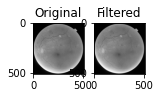

In [27]:
fig = plt.figure(figsize=(2,2))
row = 1
column = 2
img = cv2.imread('gdrive/MyDrive/cleaned_eye_images/retinopathy/101_cleaned.jpg')
# cv2.imshow('Frame',img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray,cmap='gray')
# plt.show()

## Applying Gaussian Filter
GaussFilter = np.array([[1,1,1], [1,1,1], [1,1,1]])/float(9)
Gm = scipy.signal.convolve2d(gray,GaussFilter,mode='same')
# plt.imshow(Gm,cmap='gray')
# plt.show()
imgs = np.array([gray, Gm])
labels = ['Original','Filtered']
for i in range(1, column*row+1):
    ax = fig.add_subplot(row,column,i)
    ax.set_title(labels[i-1])
    plt.imshow(imgs[i-1], cmap='gray')
plt.show()

### Median Filter

Median filter replaces each pixel in a neighbourhood with the median pixel intensity in that neighbourhood based on the filter size. This filter removes noise caused by sudden disturbances when taking an image in the form of black and white pixels.

#### Testing median filter on one image:

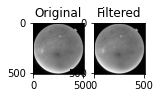

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(2,2))
row = 1
column = 2


img = cv2.imread('gdrive/MyDrive/cleaned_eye_images/retinopathy/101_cleaned.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


## Applying Median Filter
Gm = cv2.medianBlur(gray,3)

imgs = np.array([gray, Gm])
labels = ['Original','Filtered']
for i in range(1, column*row+1):
    ax = fig.add_subplot(row,column,i)
    ax.set_title(labels[i-1])
    plt.imshow(imgs[i-1], cmap='gray')
plt.show()

### Gaussian filter

Gaussian filter is a modified version of the Mean Filter where the weights of the impulse function are distributed normally around the origin. This filter reduces the noise by suppressing high frequency components. However, because of that, the images returned are blurred.

#### Testing Gaussian filter on one image:

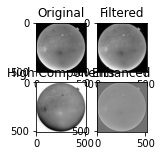

In [29]:
fig = plt.figure(figsize=(2,2))
row = 2
column = 2

Hg = np.zeros((20,20))

img = cv2.imread('gdrive/MyDrive/cleaned_eye_images/retinopathy/101_cleaned.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


for i in range(20):
    for j in range(20):
        Hg[i,j] = np.exp(-((i-10) ** 2 + (j-10)**2)/10)



## Applying Gaussian Blur
gaussian_blur = scipy.signal.convolve2d(gray, Hg, mode='same')


gray_high = gray - gaussian_blur


gray_enhanced = gray + 0.025 * gray_high

imgs = np.array([ gray, gaussian_blur, gray_high, gray_enhanced])
labels = ['Original', 'Filtered', 'High Components', 'Enhanced']
for i in range(1, column*row+1):

    ax = fig.add_subplot(row,column,i)
    ax.set_title(labels[i-1])
    plt.imshow(imgs[i-1], cmap='gray')
plt.show()

### Sobel edge detection filter

Sobel edge detection filter takes the sum of horizontal and vertical gradients at two points and gives a double weight to the point of interest. This is a high-pass filter since it passes only high frequency components within the image.

#### Testing Sobel edge detection filter on one image:


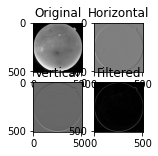

In [30]:
fig = plt.figure(figsize=(2,2))
row = 2
column = 2



img = cv2.imread('gdrive/MyDrive/cleaned_eye_images/retinopathy/101_cleaned.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# plt.imshow(gray, cmap='gray')
# plt.show()

## Applying Median Filter to reduce Salt and Pepper Noise
Gm = cv2.medianBlur(gray,3)
# plt.imshow(Gm,cmap='gray')
# plt.show()

Hx = np.array([[1,0,-1], [2,0,-2],[1,0,-1]], dtype=np.float32)
Hy = np.array([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=np.float32)
Gx = scipy.signal.convolve2d(Gm, Hx, mode ='same')
Gy = scipy.signal.convolve2d(Gm,Hy,mode = 'same')

# plt.imshow(Gx, cmap='gray')
# plt.show()
# plt.imshow(Gy, cmap='gray')
# plt.show()

G = (Gx*Gx + Gy*Gy) ** 0.5 
# plt.imshow(G, cmap='gray')
# plt.show()

imgs = np.array([ gray, Gx, Gy, G ])
labels = ['Original', 'Horizontal', 'Vertical', 'Filtered']
for i in range(1, column*row+1):

    ax = fig.add_subplot(row,column,i)
    ax.set_title(labels[i-1])
    plt.imshow(imgs[i-1], cmap='gray')
plt.show()

#### A short summary of the most common filter and their use:

![](https://drive.google.com/uc?export=view&id=1IVwYwudBL84eLsgGBfMrKsMU5wZ6s3X9)

## Image Convolutions

General expression of a convolution.

![](https://drive.google.com/uc?export=view&id=1glLIQa1kvxe__Y29iIJ9RWJAbQpv3I9p)


Convolution pseudocode:

![](https://drive.google.com/uc?export=view&id=1mTNJksd9-J_OjfCTq6ks5S_mRROenY3n)

Since we converted all our images to arrays, now we have a set of matrices. Convolution is an element-wise multiplication of two matrices followed by a sum (reference [4]). Convolutions use kernels, which are smaller matrices that slide from left-to-right and top-to-bottom along the original image. At each x, y-coordinate, the center of the neighborhood is convolved with the kernel and a single output value is obtained. Kernels can be an arbitrary size, but most often they are square matrices.

An image convolution requires three components:

1. An input image
2. A kernel matrix that will be applied to an image
3. An output image to store the image convolved with the kernel.


Convolutions require grey images, therefore all images were converted to grey scale before. In addition, the output images will be decreased in spatial dimension.

Our above filters can be used as kernels. I will use Gaussian filter as a kernel.

### Defining Gaussian kernel:

In [31]:

def _filter_kernel_mf_fdog(L, sigma, t = 3, mf = True):
    dim_y = int(L)
    dim_x = 2 * int(t * sigma)
    arr = np.zeros((dim_y, dim_x), 'f')
    
    ctr_x = dim_x / 2 
    ctr_y = int(dim_y / 2.)

    # x's are actually columns, so the first dimension of the iterator is used
    it = np.nditer(arr, flags=['multi_index'])
    while not it.finished:
        arr[it.multi_index] = it.multi_index[1] - ctr_x
        it.iternext()

    two_sigma_sq = 2 * sigma * sigma
    sqrt_w_pi_sigma = 1. / (sqrt(2 * pi) * sigma)
    if not mf:
        sqrt_w_pi_sigma = sqrt_w_pi_sigma / sigma ** 2

    #@vectorize(['float32(float32)'], target='cpu')
    def k_fun(x):
        return sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    #@vectorize(['float32(float32)'], target='cpu')
    def k_fun_derivative(x):
        return -x * sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    if mf:
        kernel = k_fun(arr)
        kernel = kernel - kernel.mean()
    else:
        kernel = k_fun_derivative(arr)

    # return the "convolution" kernel for filter2D
    return cv2.flip(kernel, -1) 

def gaussian_matched_filter_kernel(L, sigma, t = 3):
    '''
    K =  1/(sqrt(2 * pi) * sigma ) * exp(-x^2/2sigma^2), |y| <= L/2, |x| < s * t
    '''
    return _filter_kernel_mf_fdog(L, sigma, t, True)



#Creating a matched filter bank using the kernel generated from the above functions
def createMatchedFilterBank(K, n = 12):
    rotate = 180 / n
    center = (K.shape[1] / 2, K.shape[0] / 2)
    cur_rot = 0
    kernels = [K]

    for i in range(1, n):
        cur_rot += rotate
        r_mat = cv2.getRotationMatrix2D(center, cur_rot, 1)
        k = cv2.warpAffine(K, r_mat, (K.shape[1], K.shape[0]))
        kernels.append(k)

    return kernels

def applyFilters(im, kernels):

    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)

#### Applyting convolution to retinopathic images:

In [32]:
gf = gaussian_matched_filter_kernel(20, 5)
bank_gf = createMatchedFilterBank(gf, 4)

retin_gauss = []
for equ2 in retin_haar:
    equ2 = equ2.reshape((512, 512))
    equ3 = applyFilters(equ2,bank_gf)
    retin_gauss.append(np.array(equ3).flatten())

#### Visualizing convolved retinopathic image:

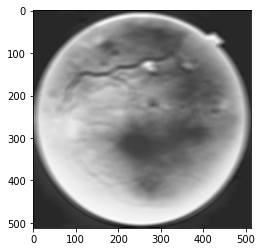

In [33]:
np.shape(retin_gauss)
plt.imshow(retin_gauss[60].reshape((512, 512)),cmap='gray')
plt.show()

### Applying convolution to normal images:

In [34]:
gf = gaussian_matched_filter_kernel(20, 5)
bank_gf = createMatchedFilterBank(gf, 4)

norm_gauss = []
for equ2_n in norm_haar:
    equ2_n = equ2_n.reshape((512, 512))
    equ3_n = applyFilters(equ2_n,bank_gf)
    norm_gauss.append(np.array(equ3_n).flatten())

#### Visualizing convoluted normal image:

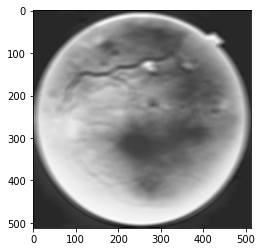

In [35]:
np.shape(norm_gauss)
plt.imshow(norm_gauss[60].reshape((512, 512)),cmap='gray')
plt.show()

#### Converting normal image arrays to images and saving them:

In [ ]:
from PIL import Image as im
import numpy as np

#image = norm_gauss[60].reshape(1424,2144)
# Creates PIL image
#img = Image.fromarray(np.uint8(image))
#im2 = np.array(img)



In [ ]:
#gray = cv2.cvtColor(np.ascontiguousarray(img), cv2.COLOR_RGB2GRAY)
#cv2.imwrite ('/content/gdrive/MyDrive/sample_output.png', im2)

In [ ]:
#image = norm_gauss[5].reshape(1424,2144)
# Creates PIL image
#img = Image.fromarray(np.uint8(image))
#im2 = np.array(img)
#a = str(i)
#name = "/content/gdrive/MyDrive/images/" + a +".png"
#cv2.imwrite (name, im2)

In [ ]:
#for i in range(0, 300):
#  image = norm_gauss[i].reshape(1424,2144)
# Creates PIL image
#  img = Image.fromarray(np.uint8(image))
#  im2 = np.array(img)
#  a = str(i)
#  name = "/content/gdrive/MyDrive/images_normal_gauss/" + a +".png"
#  cv2.imwrite (name, im2)

#### Converting diabetic image arrays to images and saving them:

In [ ]:
#for i in range(0, 300):
#  image = norm_gauss[i].reshape(1424,2144)
# Creates PIL image
#  img = Image.fromarray(np.uint8(image))
#  im2 = np.array(img)
#  a = str(i)
#  name = "/content/gdrive/MyDrive/images_diabetic_gauss/" + a +".png"
#  cv2.imwrite (name, im2)

# Modeling

## SVM

#### Setting X and y:

In [37]:
# X should contain both normal and retinopathic images:
X = retin_gauss + norm_gauss 
# convert to array and check shape
X_arr = np.array(X)
print(f'X shape: {X_arr.shape}')

# 1 for retinopathy, 0 for normal
y = [1] * 300 + [0] * 476
# convert to array and check shape
y = np.array(y)
print(f'y shape: {y.shape}')

X shape: (776, 262144)
y shape: (776,)


#### Train test split:


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### Instantiating support vector machine:

In [41]:
svc = SVC(gamma="scale")

#### Fitting support vector machine to training data:


In [42]:
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### Generating predictions:


In [43]:
y_pred = svc.predict(X_test)

#### Measuring performance based on accuracy score:

In [45]:
accuracy_score(y_test, y_pred)

0.6070038910505836

In [46]:
train_preds = svc.predict(X_train)

In [47]:
accuracy_score(y_train, train_preds)

0.6165703275529865

As we can see accuracy score is no better than the baseline score.

#### Grid Search for best parameters:

In [48]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

In [49]:
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.615, total= 1.1min
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.615, total= 1.1min
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.615, total= 1.1min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.615, total= 1.1min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.621, total= 1.1min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.615, total= 1.1min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.615, total= 1.1min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.615, total= 1.1min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.615, total= 1.1min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 142.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [50]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


#### Predicting using grid search best parameters:

In [51]:
grid_predictions = grid.predict(X_test)

#### Printing Classification report:

In [53]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.61      1.00      0.76       156
           1       0.00      0.00      0.00       101

    accuracy                           0.61       257
   macro avg       0.30      0.50      0.38       257
weighted avg       0.37      0.61      0.46       257



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The SVM model returned poor f1-score and cannot be used for the medical diagnoses classification. Further improvements on the image processing might improve the model.

## KNN Neighbor Classifier

#### Initializing classifier and the grid search

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

pipe = Pipeline([
        ('sc', StandardScaler()),     
        ('knn', KNeighborsClassifier(algorithm='brute')) 
    ])
params = {
        'knn__n_neighbors': [3, 5, 7, 9, 11] 
    }
clf = GridSearchCV(estimator=pipe,           
                      param_grid=params, 
                      cv=5,
                      return_train_score=True) 
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('sc',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='brute',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             i

#### Printing best parameters:

In [59]:
# print best parameter after tuning
print(clf.best_params_)

{'knn__n_neighbors': 3}


In [61]:
# print how our model looks after hyper-parameter tuning
print(clf.best_estimator_)

Pipeline(memory=None,
         steps=[('sc',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('knn',
                 KNeighborsClassifier(algorithm='brute', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=3, p=2,
                                      weights='uniform'))],
         verbose=False)


#### Making predictions:

In [63]:
grid_predictions_knn = clf.predict(X_test)

#### Printing classification report:

In [64]:
print(classification_report(y_test, grid_predictions_knn))

              precision    recall  f1-score   support

           0       0.61      1.00      0.76       156
           1       0.00      0.00      0.00       101

    accuracy                           0.61       257
   macro avg       0.30      0.50      0.38       257
weighted avg       0.37      0.61      0.46       257



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The KNN model also returned poor results.

# References:
1. A guide for using the Wavelet Transform in Machine Learning: https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
2.Wavelet transforms with Python: https://pywavelets.readthedocs.io/en/latest/
3. Image Processing: https://medium.com/journey-to-machine-learning-deep-learning/chapter-five-image-processing-e5b92ee87c0b
4. Convolutions with Python and OpenCV: https://www.pyimagesearch.com/2016/07/25/convolutions-with-opencv-and-python/
5. Kernel filter: https://en.wikipedia.org/wiki/Kernel_(image_processing)
6. OpenCV K-means clustering: https://docs.opencv.org/4.5.2/d5/d38/group__core__cluster.html